In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

# DU-GD法（二次関数）
### 準備 (グローバル定数の設定)

In [2]:
n = 100
num_itr = 30
train_itr = 25
K = 50
adam_lr = 1e-3
max_inner = 20

In [3]:
A = np.diag(np.arange(1,100+1))
lambda_min = 1
lambda_max = n
eta_opt = 2/(lambda_min + lambda_max)

### 固定ステップサイズのGD法の二乗誤差

In [4]:
def GD(max_itr, x0):
    x = x0
    for i in range(max_itr):
        x -= eta_opt * A @ x
    return x

def comp_se(max_itr, x0):
    x_hat = GD(max_itr, x0)
    return np.linalg.norm(x_hat)**2

In [5]:
x_init = np.random.randn(n)
GD_mse = [comp_se(i, x_init) for i in range(num_itr)]

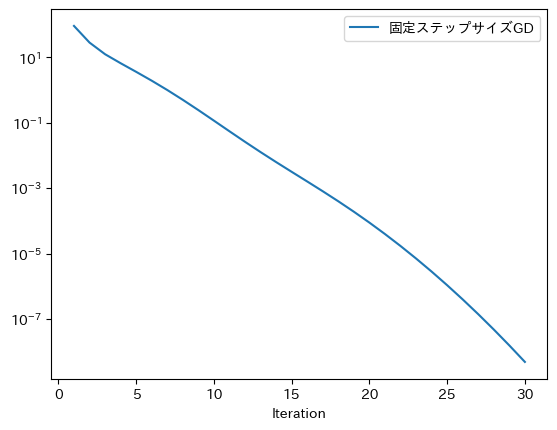

In [6]:
df = pd.DataFrame()
df["Iteration"]  = range(1, num_itr+1)
df["固定ステップサイズGD"] = GD_mse
df.plot("Iteration", "固定ステップサイズGD")
plt.yscale('log')

### DU-GD反復の定義 

In [7]:
A = jnp.array(A)
@partial(jax.jit, static_argnums=0)
def DU_GD(max_itr, x0, eta, T):
    x = x0
    for i in range(max_itr):
        k = (i % T)
        x -= eta[k] * A @ x
    return x

### 損失関数の定義

In [8]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

@partial(jax.jit, static_argnums=0)
def loss(max_itr, x0, T, eta):
    x_hat = DU_GD(max_itr, x0, eta, T)
    return jnp.sum(batch_get_dot(x_hat))/K

### 訓練関数の定義

In [9]:
#Adamオプティマイザを利用
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=0)
def step(max_itr, x0, T, step, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(max_itr, x0, T, get_params(opt_state))
    new_opt_state = opt_update(step, grads, opt_state)
    return value, new_opt_state

def train(eta, T, train_itr):
    opt_state = opt_init(eta)
    rng = jax.random.PRNGKey(11)
    for itr in trange(train_itr, leave=False):
        for i in range(max_inner):
            rng, subkey = jax.random.split(rng, num=2)
            x0 = jax.random.normal(subkey, (n, K))
            value, opt_state = step(itr+1, x0, T, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

### 学習過程

In [10]:
T = 3
eta_init = jnp.zeros(num_itr)
eta_trained = train(eta_init, T, train_itr)

  0%|          | 0/25 [00:00<?, ?it/s]

loss:0.2945044934749603  

In [11]:
eta_trained

Array([0.02383416, 0.01122499, 0.04485677, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float32)

In [12]:
DUGD_mes = [loss( i, x_init.reshape(-1,1), T, eta_trained) for i in range(num_itr)]
opt_param1 = [eta_trained[(i%T)] for i in range(num_itr)]

In [13]:
df["DU-GD T=3"] = np.array(DUGD_mes)
df["T=3"] = np.array(opt_param1)
df["eta_opt"] = [eta_opt]*num_itr

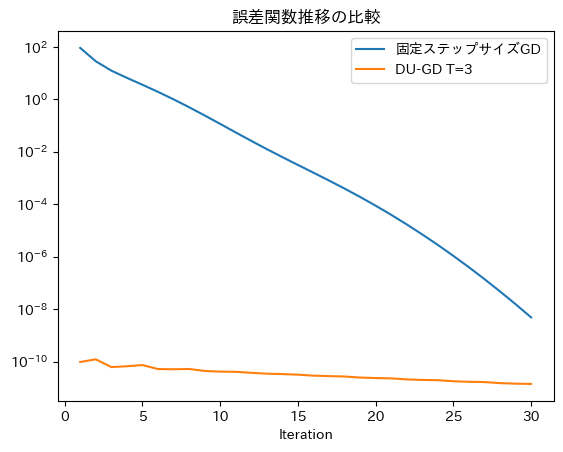

In [14]:
df.plot("Iteration", ["固定ステップサイズGD", "DU-GD T=3"])
plt.yscale("log")
plt.title("誤差関数推移の比較");

### 最適パラメータのプロット

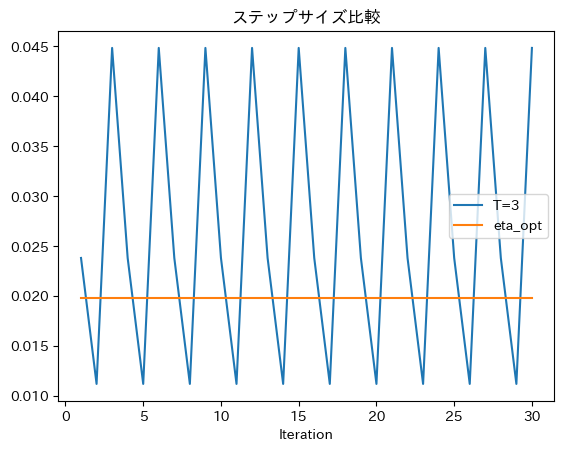

In [15]:
df.plot("Iteration", ["T=3", "eta_opt"])
plt.title("ステップサイズ比較");